# Low-Vol systematic trading strategy

The strategy aims at benefiting from the low-volatility anomaly, where the standard positive relationship between returns and volatility does not hold. The final portfolio invests in securities with the lowest annual volatility. The sample of stocks is divided into five quantiles based on the total volatility of the previous year and rebalanced monthly. 

In [ ]:
import os
notebook_path = os.getcwd()
print(notebook_path)

In [ ]:
path = "/Users/stefanogrillini/Documents/GitHub/Low-Vol-systematic-strategy/"
os.chdir(path)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from datetime import date
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import math
import hvplot.pandas
import holoviews as hv
from arch import arch_model
hv.extension('bokeh')
import my_risk_kit as erk

/Users/stefanogrillini/Documents/GitHub/Low-Vol-systematic-strategy/my_risk_kit.py:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filetype is "returns":
/Users/stefanogrillini/Documents/GitHub/Low-Vol-systematic-strategy/my_risk_kit.py:49: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "nfirms":
/Users/stefanogrillini/Documents/GitHub/Low-Vol-systematic-strategy/my_risk_kit.py:52: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "size":


We fetch the names and Adjusted Closing Prices of the first 100 securities listed in the S&P 500 index as well as the benchmark.
Then we drop companies with missing data. 

In [4]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = np.array(sp500[0]['Symbol'])

In [5]:
data = pd.DataFrame(columns = sp500_list[:100])
for i in data.columns:
    data[i] = yf.download(
    i, 
    start='2016-01-05', 
    end=date.today(),
    progress = False
)['Adj Close']

symbol_benchmark = "^SPX"
benchmark = yf.download(
    symbol_benchmark, 
    start='2016-01-05', 
    end=date.today()
)['Adj Close']


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


In [6]:
for col in data:
   if data[col].isna().sum() > 0:
      print(col)

ABNB
BRK.B
BF.B
CARR


In [7]:
benchmark.isnull().values.any()

False

In [8]:
data.drop(['ABNB','BRK.B','BF.B', 'CARR'], axis=1, inplace = True)
           
           
         #  , 'CDAY', 'CEG', 'CTVA', 'DOW', 'FTV'
         #  , 'FOXA', 'FOX', 'GEHC', 'HWM', 'IR', 'INVH', 'KVUE', 'LW'
         #  , 'MRNA', 'OGN', 'OTIS', 'VICI'], axis=1, inplace = True)

No we report some summary statistics and we compare the comulative performance of the S&P 500 Index vs a simple equally weighted average of the first 100 stocks.

In [9]:
# Some summary stats of the selected stocks
returns = data.pct_change().shift(1)
returns.dropna(inplace = True)
bench_ret = benchmark.pct_change().shift(1)
erk.summary_stats(returns, riskfree_rate=0.04/250, periods_per_year=250)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
MMM,-0.015949,0.244359,-0.399827,12.325188,0.024160,0.038046,-0.065914,-0.560702
AOS,0.095557,0.277753,0.310577,7.442648,0.025211,0.039632,0.343403,-0.468063
ABT,0.137148,0.244384,-0.154393,9.869807,0.023312,0.035928,0.560453,-0.316732
ABBV,0.185486,0.264689,-0.666675,15.727528,0.025439,0.039147,0.700055,-0.450898
ACN,0.175671,0.255076,0.212161,9.679831,0.022591,0.038784,0.687962,-0.396878
...,...,...,...,...,...,...,...,...
CBOE,0.128992,0.254847,-0.525580,14.676275,0.024415,0.036782,0.505447,-0.440797
CBRE,0.112061,0.341029,0.028885,12.637627,0.030439,0.050777,0.328075,-0.535720
CDW,0.247805,0.296328,-0.304315,11.490723,0.028134,0.043622,0.835580,-0.448341
CE,0.110958,0.326538,-0.396828,10.566005,0.032441,0.048325,0.339257,-0.533295


In [10]:
# Let's start with a simple equally-weighted portfolio
ew_average = returns.mean(axis=1)
ew_portfolio = pd.DataFrame({'SP500': bench_ret, 'Equally-weighted average': ew_average}, index = returns.index)
ew_portfolio.isnull().values.any()

False

In [11]:
ew_portfolio.corr()

,SP500,Equally-weighted average
SP500,1.000000,0.967943
Equally-weighted average,0.967943,1.000000


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SP500,0.107236,0.187482,-0.542787,17.901155,0.017219,0.029285,0.344871,-0.33925
Equally-weighted average,0.164891,0.198635,-0.558733,18.571241,0.017943,0.030486,0.604646,-0.38243


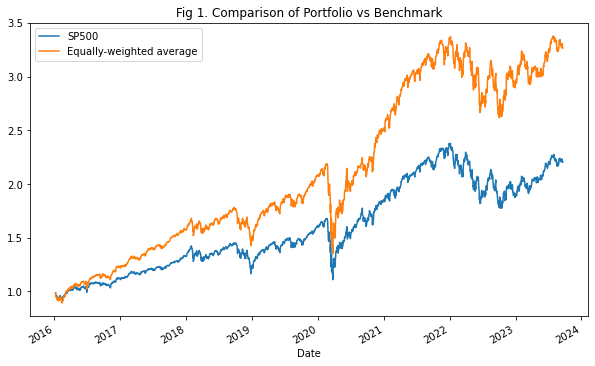

In [12]:
(1+ew_portfolio).cumprod().plot(figsize=(10,6), title="Fig 1. Comparison of Portfolio vs Benchmark")
erk.summary_stats(ew_portfolio.dropna(), riskfree_rate=0.04, periods_per_year=250)

Overall, a simple portfolio with equally weighted returns for the first 100 stocks of the S&P 500 Index yields better performances. In the literature this is explained by the overweight that some stocks have in the index such that its performances are mainly driven by the performances of the top contributors. 

In [13]:
# Convert from daily to monthly prices using 'M'
data_monthly = data.resample('M').last()

# Drop the columns with insufficient data
data_monthly_clean = data_monthly.dropna(axis=1)

In [14]:
data_monthly_clean.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AES,...,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,COR
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,116.267067,30.848156,32.970314,39.661060,93.252800,32.943642,28.415321,89.129997,70.415260,7.392311,...,63.826958,44.180000,42.007374,23.530001,51.135273,64.219360,27.969999,35.204666,53.964764,79.067101
2016-02-29,121.659531,31.192013,33.745579,39.451553,88.587524,29.963387,28.358229,85.150002,71.771172,7.625754,...,64.085815,46.259998,42.139801,24.270000,55.621124,60.247841,25.410000,36.340034,51.413242,76.769905
2016-03-31,129.228867,33.820164,36.437214,41.264832,101.964897,32.276989,29.453302,93.800003,76.499680,9.182031,...,64.587418,51.099998,46.366081,26.670000,62.883907,63.205479,28.820000,38.102863,55.809864,76.707855
2016-04-30,129.810532,34.326412,34.091949,44.491280,100.742378,32.877892,32.397820,94.220001,75.416695,8.768779,...,61.836823,52.950001,43.097527,29.530001,64.475975,59.945068,29.629999,35.348446,60.545406,75.422729
2016-05-31,131.408752,36.584606,34.731724,45.898964,106.139931,37.446648,34.972214,99.470001,74.905060,8.713781,...,62.223022,53.660000,42.237331,28.120001,60.153793,61.580112,29.850000,39.175209,60.357010,66.755600


## Build Low Vol indicator and loop across all dates

In [15]:
monthly_returns = data_monthly_clean.pct_change().shift(1)
monthly_returns = monthly_returns.dropna(axis=0)

<AxesSubplot:xlabel='Date'>

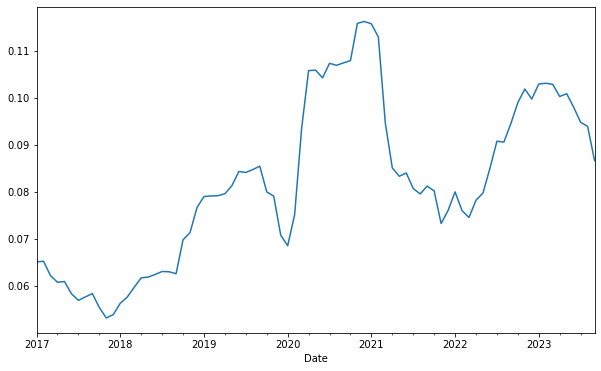

In [16]:
# 1st Signal: Low Vol indicator
vol_12 = data_monthly_clean.pct_change().rolling(window=12).std()
# Drop the 1 or 2 rows with NA's
vol_12 = vol_12.dropna(axis=0)
vol_12.mean(axis = 1).plot(figsize = (10,6))

<AxesSubplot:xlabel='Date'>

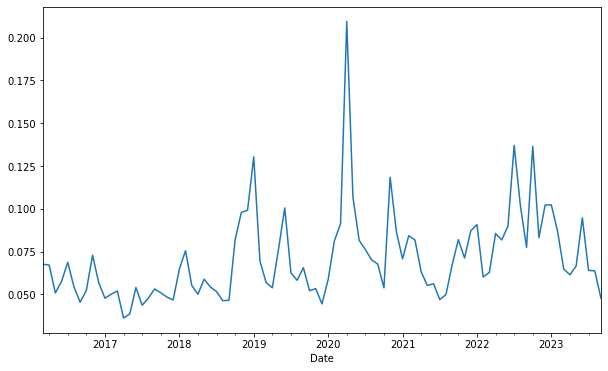

In [17]:
# 2nd Signal: Low Vol indicator using EWMA, with decay factor alpha = 0.94
vol_ewma = data_monthly_clean.pct_change().ewm(alpha = 0.9, adjust = True).std()
# Drop the 1 or 2 rows with NA's
vol_ewma = vol_ewma.dropna(axis=0)
vol_ewma.mean(axis = 1).plot(figsize = (10,6))

In [26]:
vol_ranks = factor_rank(vol_12, 5)
vol_ranks_ewma = factor_rank(vol_ewma, 5)

In [27]:
quintile_dfs = {}
vol_returns = pd.DataFrame()

# Iterate for each quintile, and form portfolios accordingly
for quintile in range(5):
    
    # Only take returns if they're in quintile associated with the current loop.
    filtered_df = monthly_returns[vol_ranks == quintile]
    
    # shift to "t+1" return as rank at time "t" corresponds to return at time "t+1"
    filtered_df_shifted = filtered_df.shift(-1).dropna(how='all',axis=0)

    # Put those returns into dictionary "quintile_dfs"
    quintile_dfs[quintile] = filtered_df_shifted

    #For Equal-Weight, simply take the average return across stocks within each quintile dataframe
    vol_returns[quintile] = quintile_dfs[quintile].mean(axis=1).dropna()

In [28]:
quintile_ewma_dfs = {}
vol_returns_ewma = pd.DataFrame()

# Iterate for each quintile, and form portfolios accordingly
for quintile in range(5):
    
    # Only take returns if they're in quintile associated with the current loop.
    filtered_df = monthly_returns[vol_ranks_ewma == quintile]
    
    # shift to "t+1" return as rank at time "t" corresponds to return at time "t+1"
    filtered_df_shifted = filtered_df.shift(-1).dropna(how='all',axis=0)

    # Put those returns into dictionary "quintile_dfs"
    quintile_ewma_dfs[quintile] = filtered_df_shifted

    #For Equal-Weight, simply take the average return across stocks within each quintile dataframe
    vol_returns_ewma[quintile] = quintile_ewma_dfs[quintile].mean(axis=1).dropna()

In [29]:
vol_returns.rename(columns = {0: 'Very Low Vol', 1: 'Low Vol', 2: 'Medium', 3: 'High Vol', 4: 'Very High Vol'}, inplace = True)
vol_returns.describe()

,Very Low Vol,Low Vol,Medium,High Vol,Very High Vol
count,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.012074,0.013701,0.011815,0.012746,0.019424
std,0.030297,0.041577,0.050338,0.061875,0.096421
min,-0.074844,-0.102973,-0.113523,-0.160246,-0.379117
25%,-0.001550,-0.005312,-0.015622,-0.019777,-0.013577
50%,0.015646,0.016293,0.013784,0.022324,0.023366
75%,0.033426,0.037547,0.043193,0.052633,0.054764
max,0.076310,0.109173,0.128944,0.162564,0.300104


In [30]:
vol_returns_ewma.rename(columns = {0: 'Very Low Vol', 1: 'Low Vol', 2: 'Medium', 3: 'High Vol', 4: 'Very High Vol'}, inplace = True)
vol_returns_ewma.describe()

,Very Low Vol,Low Vol,Medium,High Vol,Very High Vol
count,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.008872,0.010271,0.014591,0.016447,0.024947
std,0.025072,0.036997,0.048179,0.060878,0.106184
min,-0.074261,-0.100084,-0.113895,-0.192489,-0.390587
25%,-0.005180,-0.012317,-0.005257,-0.012282,-0.028847
50%,0.013589,0.015705,0.016406,0.021285,0.034168
75%,0.024859,0.029905,0.043487,0.050626,0.087936
max,0.056852,0.095429,0.124999,0.134429,0.326843


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Very Low Vol,0.148692,0.104951,-0.699617,3.670408,0.042755,0.061178,0.999032,-0.123801
Low Vol,0.165533,0.144028,-0.467850,3.133938,0.059477,0.077623,0.840698,-0.174729
Medium,0.134369,0.174378,-0.310640,3.038905,0.074759,0.096856,0.521828,-0.229380
High Vol,0.138031,0.214340,-0.470254,3.258118,0.096043,0.124134,0.440885,-0.320912
Very High Vol,0.190334,0.334012,-0.504748,6.702575,0.144323,0.200152,0.433589,-0.463016


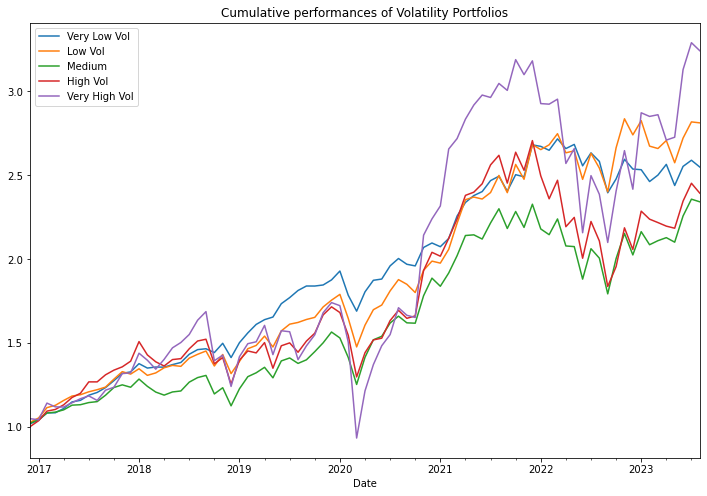

In [31]:
# Plot the cumulative return
(1+vol_returns).cumprod().plot(figsize = (12, 8), title = "Cumulative performances of Volatility Portfolios")
erk.summary_stats(vol_returns, riskfree_rate=0.04, periods_per_year=12)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Very Low Vol,0.108,0.087,-0.961,4.107,0.038,0.055,0.752,-0.182
Low Vol,0.121,0.128,-0.469,3.803,0.054,0.080,0.612,-0.232
Medium,0.174,0.167,-0.475,3.376,0.070,0.098,0.773,-0.210
High Vol,0.190,0.211,-0.628,3.852,0.092,0.125,0.685,-0.256
Very High Vol,0.256,0.368,-0.494,5.267,0.158,0.220,0.565,-0.449


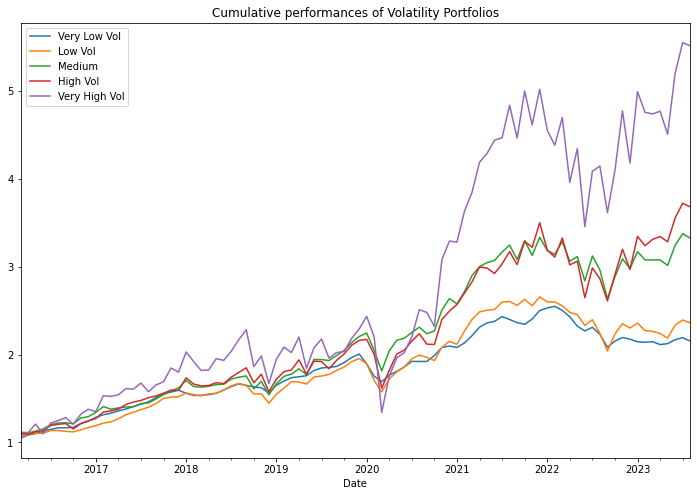

In [32]:
# Plot the cumulative return
(1+vol_returns_ewma).cumprod().plot(figsize = (12, 8), title = "Cumulative performances of Volatility Portfolios")
round(erk.summary_stats(vol_returns_ewma, riskfree_rate=0.04, periods_per_year=12), 3)

In [33]:
# Convert from daily to monthly also the SP500
bench_monthly = benchmark.resample('M').last()
bench_ret_monthly = bench_monthly.pct_change()
bench_ret_monthly.isnull().values.any()

True

In [34]:
vol_ranks.columns[vol_ranks.iloc[-1] == 4]

Index(['ALK', 'ALB', 'ALGN', 'AMD', 'AAL', 'APA', 'AMAT', 'APTV', 'ANET',
       'AXON', 'BKR', 'BX', 'BA', 'BXP', 'CZR', 'COF', 'CCL', 'CTLT', 'CAT'],
      dtype='object')

In [35]:
bench_ret_monthly.dropna(inplace = True)

In [36]:
low_vol_df = pd.DataFrame({'SP500': bench_ret_monthly, 'Low Vol std': vol_returns['Very Low Vol'], 'Low Vol ewma': vol_returns_ewma['Very Low Vol']}, index = vol_returns.index)
low_vol_df.dropna(inplace = True)

In [37]:
low_vol_df.describe()

,SP500,Low Vol std,Low Vol ewma
count,81.000000,81.000000,81.000000
mean,0.010039,0.012074,0.007427
std,0.047773,0.030297,0.025547
min,-0.125119,-0.074844,-0.074261
25%,-0.011137,-0.001550,-0.008391
50%,0.017924,0.015646,0.012781
75%,0.036022,0.033426,0.023619
max,0.126844,0.076310,0.056852


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SP500,0.112,0.165,-0.497,3.399,0.074,0.096,0.421,-0.248
Low Vol std,0.149,0.105,-0.700,3.670,0.043,0.061,0.999,-0.124
Low Vol ewma,0.089,0.088,-0.923,3.902,0.040,0.055,0.530,-0.182


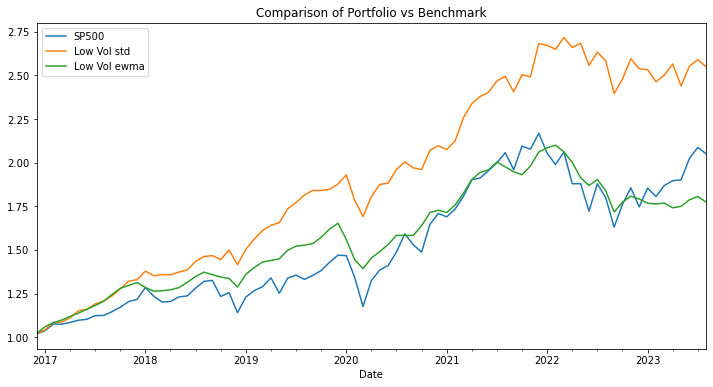

In [38]:
(1+low_vol_df).cumprod().plot(figsize=(12,6), title="Comparison of Portfolio vs Benchmark")
round(erk.summary_stats(low_vol_df.dropna(), riskfree_rate=0.04, periods_per_year=12), 3)

The Low Vol signal using standard deviation outperform the EWMA signal and the market portfolio, with 15% annualized returns vs 11% and 9%, respectively and SR=1, as well as lower drawdown. However, there is higher volatility as compared to the smoothed signal.

We now test different windows for the simple Low Vol signal using daily data and we take the monthly average for signal generation

In [39]:
# Low Vol indicator from daily data
vol_20_daily = data.pct_change().rolling(window=20).std()
vol_60_daily = data.pct_change().rolling(window=60).std()
vol_120_daily = data.pct_change().rolling(window=120).std()
# Drop the rows with NA's
vol_20_daily = vol_20_daily.dropna(axis=0)
vol_60_daily = vol_60_daily.dropna(axis=0)
vol_120_daily = vol_120_daily.dropna(axis=0)

# Convert from daily to monthly prices using 'M'
vol_20 = vol_20_daily.resample('M').mean().dropna(axis=1)
vol_60 = vol_60_daily.resample('M').mean().dropna(axis=1)
vol_120 = vol_120_daily.resample('M').mean().dropna(axis=1)

<AxesSubplot:xlabel='Date'>

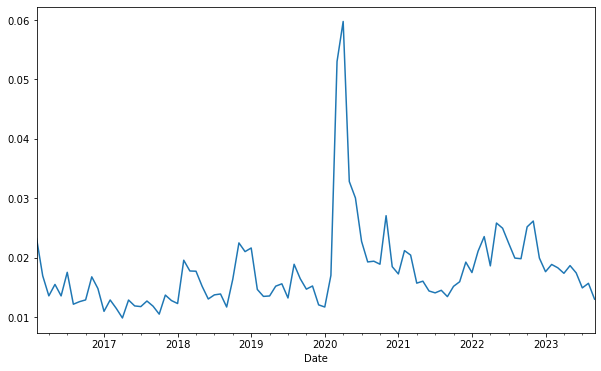

In [40]:
vol_20.mean(axis = 1).plot(figsize = (10,6))

<AxesSubplot:xlabel='Date'>

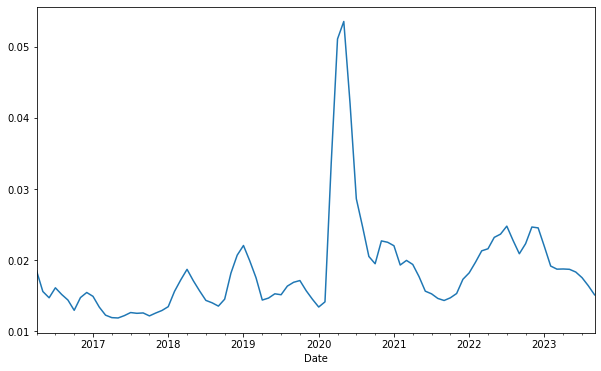

In [41]:
vol_60.mean(axis = 1).plot(figsize = (10,6))

<AxesSubplot:xlabel='Date'>

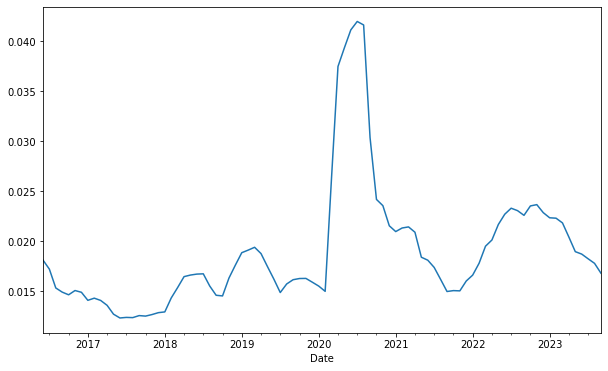

In [42]:
vol_120.mean(axis = 1).plot(figsize = (10,6))

In [43]:
vol_ranks_20 = factor_rank(vol_20, 5)
vol_ranks_60 = factor_rank(vol_60, 5)
vol_ranks_120 = factor_rank(vol_120, 5)

In [44]:
quintile_dfs_20 = {}
vol_returns_20 = pd.DataFrame()

# Iterate for each quintile, and form portfolios accordingly
for quintile in range(5):
    
    # Only take returns if they're in quintile associated with the current loop.
    filtered_df = monthly_returns[vol_ranks_20 == quintile]
    
    # shift to "t+1" return as rank at time "t" corresponds to return at time "t+1"
    filtered_df_shifted = filtered_df.shift(-1).dropna(how='all',axis=0)

    # Put those returns into dictionary "quintile_dfs"
    quintile_dfs_20[quintile] = filtered_df_shifted

    #For Equal-Weight, simply take the average return across stocks within each quintile dataframe
    vol_returns_20[quintile] = quintile_dfs_20[quintile].mean(axis=1).dropna()

In [45]:
quintile_dfs_60 = {}
vol_returns_60 = pd.DataFrame()

# Iterate for each quintile, and form portfolios accordingly
for quintile in range(5):
    
    # Only take returns if they're in quintile associated with the current loop.
    filtered_df = monthly_returns[vol_ranks_60 == quintile]
    
    # shift to "t+1" return as rank at time "t" corresponds to return at time "t+1"
    filtered_df_shifted = filtered_df.shift(-1).dropna(how='all',axis=0)

    # Put those returns into dictionary "quintile_dfs"
    quintile_dfs_60[quintile] = filtered_df_shifted

    #For Equal-Weight, simply take the average return across stocks within each quintile dataframe
    vol_returns_60[quintile] = quintile_dfs_60[quintile].mean(axis=1).dropna()

In [46]:
quintile_dfs_120 = {}
vol_returns_120 = pd.DataFrame()

# Iterate for each quintile, and form portfolios accordingly
for quintile in range(5):
    
    # Only take returns if they're in quintile associated with the current loop.
    filtered_df = monthly_returns[vol_ranks_120 == quintile]
    
    # shift to "t+1" return as rank at time "t" corresponds to return at time "t+1"
    filtered_df_shifted = filtered_df.shift(-1).dropna(how='all',axis=0)

    # Put those returns into dictionary "quintile_dfs"
    quintile_dfs_120[quintile] = filtered_df_shifted

    #For Equal-Weight, simply take the average return across stocks within each quintile dataframe
    vol_returns_120[quintile] = quintile_dfs_120[quintile].mean(axis=1).dropna()

In [54]:
low_vol_signals = pd.DataFrame({'LV_20': vol_returns_20[1], 'LV_60': vol_returns_60[1], 'LV_120': vol_returns_120[1]}, index = vol_returns_20.index)
low_vol_signals.dropna(inplace = True)
low_vol_signals.describe()

,LV_20,LV_60,LV_120
count,88.000000,88.000000,88.000000
mean,0.014144,0.013581,0.012229
std,0.040307,0.042419,0.043434
min,-0.089553,-0.108886,-0.107495
25%,-0.003383,-0.002400,-0.011626
50%,0.016751,0.015581,0.015122
75%,0.039741,0.036418,0.039145
max,0.085403,0.117503,0.108815


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
LV_20,0.172,0.140,-0.497,3.012,0.057,0.079,0.914,-0.160
LV_60,0.163,0.147,-0.431,3.476,0.060,0.086,0.810,-0.177
LV_120,0.144,0.150,-0.285,3.090,0.062,0.082,0.669,-0.170


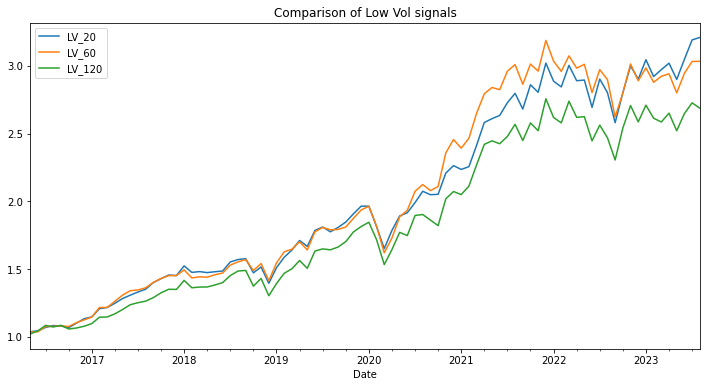

In [55]:
(1+low_vol_signals).cumprod().plot(figsize=(12,6), title="Comparison of Low Vol signals")
round(erk.summary_stats(low_vol_signals.dropna(), riskfree_rate=0.04, periods_per_year=12), 3)

# Test the portfolio vs Fama - French 3 factor model + Carhart momentum

In [ ]:
ff4 = gff.carhart4Factor(frequency = 'm')
ff4.rename(columns = {'date_ff_factors': 'Date'}, inplace = True)
ff4.set_index('Date', inplace = True)
ff4 = ff4['2016-05-01':]
ff4.head()

In [ ]:
ff_test = pd.concat([low_vol_df['Low Vol Portfolio'], ff4], axis=1)
monthly_returns
ff_test.dropna(axis = 0, inplace = True)

In [ ]:
y, x = ff_test[['Low Vol Portfolio']], ff_test[['Mkt-RF', 'SMB', 'HML', 'MOM']]
x = sm.add_constant(x) 
est = sm.OLS(y, x).fit() 
est.summary()